<a href="https://colab.research.google.com/github/blindauth/abstention_experiments/blob/master/binary_classification_simulation/BinaryClassificationSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy.stats

#simulate some data

def generate_dataset(positives_proportion, n, pos_pred_mean=2, pos_pred_std=1,
                     neg_pred_mean=-1, neg_pred_std=2, seed=1234):
    np.random.seed(seed)
    labels = []
    predicted_outputs = []
    calibrated_prob_pos = []
    for i in range(n):
        
        is_positive = np.random.random() < positives_proportion
        if (is_positive):
            output = pos_pred_std*(np.random.randn(1)[0]) + pos_pred_mean
            label = 1
        else:
            output = neg_pred_std*(np.random.randn(1)[0]) + neg_pred_mean
            label = 0
        
        labels.append(label)
        predicted_outputs.append(output)
        
        #compute p(pos) at the output value
        #Note: it's important to divide by the standard deviation to account
        # for the relative spreading of the pdf.
        positives_pdf = scipy.stats.norm.pdf((output-pos_pred_mean)/pos_pred_std)*(positives_proportion)/pos_pred_std
        negatives_pdf = scipy.stats.norm.pdf((output-neg_pred_mean)/neg_pred_std)*(1-positives_proportion)/neg_pred_std
        prob_pos = positives_pdf/(positives_pdf + negatives_pdf)
        calibrated_prob_pos.append(prob_pos)
    
    return np.array(labels), np.array(predicted_outputs), np.array(calibrated_prob_pos)
  

In [0]:
labels, pred_outputs, calib_ppos = generate_dataset(
    positives_proportion = 0.1, n=10000)

In [3]:
print(np.mean(labels))
print(np.mean(calib_ppos))

0.1094
0.10360863415730141


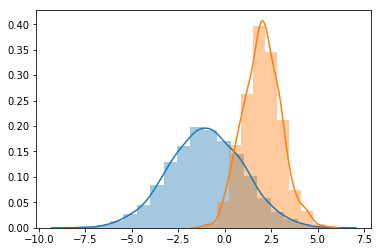

(array([  5.,  36., 115., 185., 280., 244., 149.,  52.,  23.,   5.]),
 array([-1.04760052, -0.40364498,  0.24031056,  0.8842661 ,  1.52822164,
         2.17217718,  2.81613272,  3.46008826,  4.1040438 ,  4.74799934,
         5.39195488]),
 <a list of 10 Patch objects>)

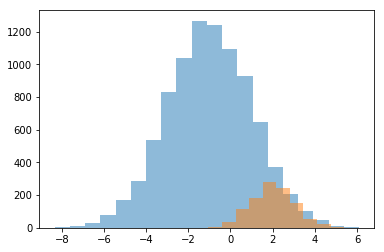

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.distplot(pred_outputs[labels==0], bins=20)
sns.distplot(pred_outputs[labels==1], bins=10)
plt.show()

plt.hist(pred_outputs[labels==0], alpha=0.5, bins=20)
plt.hist(pred_outputs[labels==1], alpha=0.5, bins=10)

0.9082085655132153


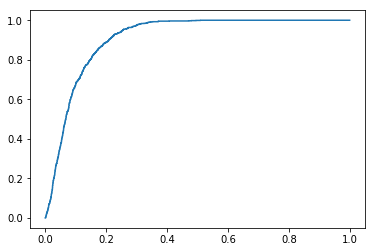

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_true=labels, y_score=pred_outputs)
print(roc_auc_score(y_true=labels, y_score=pred_outputs))

plt.plot(fpr,tpr)
plt.show()

In [6]:
!rm -r abstention
!git clone https://github.com/blindauth/abstention
!pip uninstall abstention
!pip install abstention/

Cloning into 'abstention'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 51 (delta 18), reused 42 (delta 9), pack-reused 0
Unpacking objects: 100% (51/51), done.
Uninstalling abstention-0.1.2.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/abstention-0.1.2.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/abstention/*
Proceed (y/n)? y
  Successfully uninstalled abstention-0.1.2.1
Processing ./abstention
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9yfxe7b/wheels/60/8e/d2/9e9ca02e7b5f76bfda2e2daa6dcbe42c19095c502ccb653729
Successfully built abstention


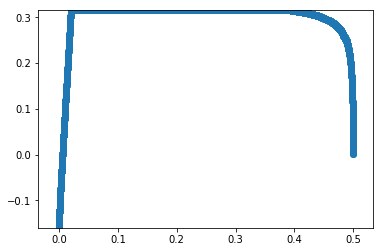

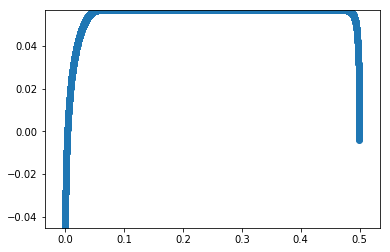

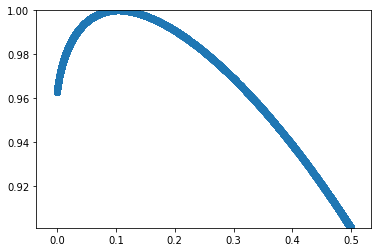

In [11]:
import scipy.signal
from abstention.abstention import (
    OneMinusJSDivFromClassFreq,
    MonteCarloWindowAbstDeltaTprAtFprThreshold,
    EstWindowAbstDeltaAuroc)

abstention_scores_windowdeltatpratfpr = MonteCarloWindowAbstDeltaTprAtFprThreshold(
    n_samples=100, fpr_threshold=0.1,
    num_to_abstain_on=int(0.3*len(calib_ppos)),
    smoothing_window_size=11,
    return_max_across_windows=True)()(posterior_probs=calib_ppos)
plt.scatter(calib_ppos, abstention_scores_windowdeltatpratfpr)
plt.ylim(np.min(abstention_scores_windowdeltatpratfpr),
         np.max(abstention_scores_windowdeltatpratfpr))
plt.show()

abstention_scores_estwindowdeltaauroc = EstWindowAbstDeltaAuroc(
  num_to_abstain_on=int(0.3*len(calib_ppos)),
  return_max_across_windows=True)()(posterior_probs=calib_ppos)
plt.scatter(calib_ppos, abstention_scores_estwindowdeltaauroc)
plt.ylim(np.min(abstention_scores_estwindowdeltaauroc),
         np.max(abstention_scores_estwindowdeltaauroc))
plt.show()

abstention_scores_jsdiv = OneMinusJSDivFromClassFreq()()(
                            posterior_probs=calib_ppos)
plt.scatter(calib_ppos, abstention_scores_jsdiv)
plt.ylim(np.min(abstention_scores_jsdiv),
         np.max(abstention_scores_jsdiv))
plt.show()


abstention percent 0.3


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


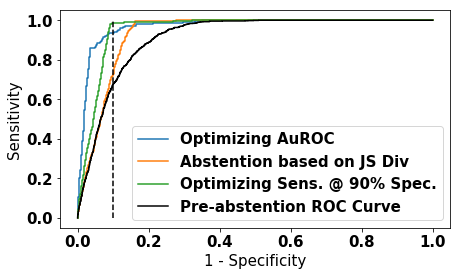

In [78]:
from matplotlib import pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

plt.figure(figsize=(7,4))
for abstention_pc in [0.3]:
  print("abstention percent", abstention_pc)
  handles = []
  for abstention_scores in [abstention_scores_estwindowdeltaauroc,
                            abstention_scores_jsdiv,                        
                            abstention_scores_windowdeltatpratfpr]:
    retained_indices = [x[0] for x in sorted(
        enumerate(abstention_scores),
        key=lambda x: x[1])[:-int(abstention_pc*
                                  len(abstention_scores))]]
    retained_calib_ppos = calib_ppos[retained_indices]
    retained_labels = labels[retained_indices]
    fpr, tpr, _ = roc_curve(y_true=retained_labels,
                            y_score=retained_calib_ppos)
    handles.append(plt.plot(fpr, tpr))

  fpr, tpr, _ = roc_curve(y_true=labels,
                          y_score=calib_ppos)
  handles.append(plt.plot(fpr, tpr, color="black"))
  plt.plot([0.1, 0.1], [0,1], color="black", linestyle="--")
  plt.legend(handles, labels=["Optimizing AuROC",
                              "Abstention based on JS Div",
                              "Optimizing Sens. @ 90% Spec.",
                              "Pre-abstention ROC Curve"])
  plt.ylabel("Sensitivity")
  plt.xlabel("1 - Specificity")
  plt.show()
  
  

In [81]:
from abstention.abstention import MonteCarloWindowAbstDeltaAuroc
from scipy.stats import spearmanr, pearsonr

#explore consistency in ranking of windows based on Monte Carlo method
# and fast estimation method
num_trials = 100
spearman_correlations = []
pearson_correlations = []
rng = np.random.RandomState(1234)
for i in range(num_trials):
    pos_pred_mean = rng.uniform(0,5)
    neg_pred_mean = pos_pred_mean - rng.uniform(0,5)
    _, _, vals = generate_dataset(
      positives_proportion = rng.uniform(low=0.1, high=0.9),
      n=1000,
      pos_pred_mean=pos_pred_mean,
      pos_pred_std=rng.uniform(1,5),
      neg_pred_mean=neg_pred_mean,
      neg_pred_std=rng.uniform(1,5))
    mc_abstention_scores = MonteCarloWindowAbstDeltaAuroc(
        n_samples=1000,
        num_to_abstain_on=int(0.1*len(vals)),
        smoothing_window_size=11,
        return_max_across_windows=True)()(posterior_probs=vals)
    est_abstention_scores = EstWindowAbstDeltaAuroc(
      num_to_abstain_on=int(0.1*len(vals)),
      return_max_across_windows=True)()(posterior_probs=vals)    
    spearman_corr = spearmanr(mc_abstention_scores, est_abstention_scores).correlation
    pearson_corr = pearsonr(mc_abstention_scores, est_abstention_scores)[0]
    print(i,"spearman", spearman_corr, "pearson", pearson_corr)
    spearman_correlations.append(spearman_corr)
    pearson_correlations.append(pearson_corr)

0 spearman 0.9999364443871873 pearson 0.9998511420245888
1 spearman 0.999453626018495 pearson 0.9994807641933315
2 spearman 0.9995414421843155 pearson 0.9999456274765086
3 spearman 0.9997298285821861 pearson 0.999578785793397
4 spearman 0.9998514262302013 pearson 0.99998991982329
5 spearman 0.9996525109778073 pearson 0.9999476430065384
6 spearman 0.9993721758388996 pearson 0.9999711726964058
7 spearman 0.9787835642137539 pearson 0.9996779386700373
8 spearman 0.9954058164794519 pearson 0.9952974969504859
9 spearman 0.9987658455844445 pearson 0.9997593857723512
10 spearman 0.9998985420418388 pearson 0.9999887888661186
11 spearman 0.9999722161911859 pearson 0.9999104771398939
12 spearman 0.9999783062867625 pearson 0.9999695844067603
13 spearman 0.9999547537129916 pearson 0.9998965902396866
14 spearman 0.9999611981632418 pearson 0.9999786963838051
15 spearman 0.9999081387655452 pearson 0.9999770059861415
16 spearman 0.9998952251308336 pearson 0.9998620638363795
17 spearman 0.99995398494353

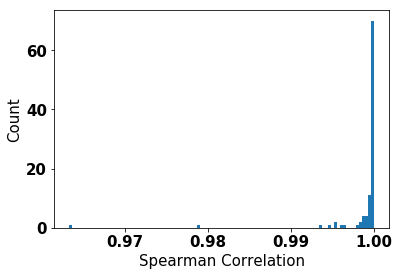

In [86]:
from matplotlib import pyplot as plt
plt.hist(spearman_correlations, bins=100)
plt.xlabel("Spearman Correlation")
plt.ylabel("Count")
plt.show()


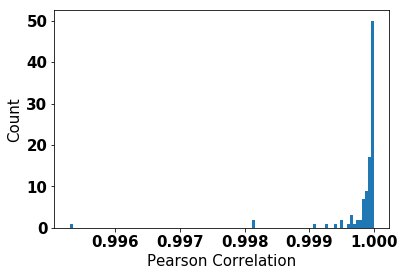

In [87]:
from matplotlib import pyplot as plt
plt.hist(pearson_correlations, bins=100)
plt.xlabel("Pearson Correlation")
plt.ylabel("Count")
plt.show()
